In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt

from pathlib import Path
import os
import sys

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch
from torch import nn
from torch import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import safetensors

from transformers import WhisperTokenizer, WhisperFeatureExtractor
from transformers import GenerationConfig
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# import LORA modules
from peft import LoraConfig
from peft import LoraModel, AdaLoraModel, PeftModel, get_peft_model

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, QuantileTransformer

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate
metric = evaluate.load("wer")

from pathlib import Path
with open("../../default_paths.txt", 'r') as file:
    lines = file.readlines()
    data_path    = Path(lines[0].strip().split("=")[1])
    project_path = Path(lines[1].strip().split("=")[1])
    
utils_path = project_path / "utils"
train_path = data_path / "train"
test_path  = data_path / "test"
sys.path.insert(0, str(utils_path))

from data_utils_lesha import (process_all_files, 
process_string, 
save_sentences_to_txt,
load_sentences_from_txt,
ModelAdaptationConfig,
PreprocessConfig,
AugmentConfig,
configure_input_layers,
configure_learnable_layers,
WhisperAugmentDataset,
DataCollatorSpeechSeq2SeqWithPadding,
count_parameters, 
save_config, 
load_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
""" LOAD PRETRAINED MODEL COMPONENTS """

WHISPER_MODEL_NAME = "openai/whisper-large-v3"

# load feature/label processing engines|
feature_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(WHISPER_MODEL_NAME, task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME)

if ".en" not in WHISPER_MODEL_NAME:
    model.generation_config.language = "english"
    model.generation_config.task = "transcribe"
    model.generation_config.forced_decoder_ids = None

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Adapt model

In [3]:
lora_config = LoraConfig(r=8, 
                         task_type="SEQ_2_SEQ_LM", 
                         use_rslora=True, 
                         use_dora=True)

adaptation_config = ModelAdaptationConfig(fs_whisper=50, 
                                          inputs_stack="concat",
                                          conv1_time_kernel_size=9, 
                                          conv2_time_kernel_size=5,
                                          conv1_out_channels=1280, 
                                          conv_layer_idx_stride_2=2,
                                          adapt_model="freeze",  # full, freeze, lora
                                          freeze_modules=("encoder", "adapter", "decoder", "sanyafreeze"), # conv, encoder, adapter, decoder, sanyafreeze
                                          low_rank_adaptation_modules=("decoder"), # encoder, decoder or full
                                          low_rank_adaptation_targets=("q_proj", "k_proj", "v_proj", "out_proj", "fc1", "fc2"), 
                                          lora_config=lora_config,
                                          n_electrodes=256, n_features=2, max_duration=30)

In [4]:
model = configure_input_layers(model, adaptation_config)

Input size:  torch.Size([10, 512, 1500])
Conv1 output size:  torch.Size([10, 1280, 1500])
Conv2 output size:  torch.Size([10, 1280, 1500])

 Number of parameters conv1:
Conv1d(512, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
Total: 5.90M, Trainable: 5.90M

Number of parameters conv2: 
Conv1d(1280, 1280, kernel_size=(5,), stride=(1,), padding=(2,))
Total: 8.19M, Trainable: 8.19M


In [5]:
model = configure_learnable_layers(model, adaptation_config)
model

Full model parameters: 
Total: 1552.17M, Trainable: 1550.25M

Freezing full model encoder layers except conv...
Freezing full model adapter layers...
Freezing full model decoder layers...
Freezing embed and proj_out layers (sanyafreeze)...

Parameters after FREEZE: 
Total: 1552.17M, Trainable: 14.09M


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(512, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv2): Conv1d(1280, 1280, kernel_size=(5,), stride=(1,), padding=(2,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bia

## Load previous checkpoint

In [6]:
prev_experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP2_encoder"
checkpoint_path = prev_experiment_path / "checkpoint-2750"

weights1 = safetensors.torch.load_file(checkpoint_path / "model-00001-of-00002.safetensors")
weights2 = safetensors.torch.load_file(checkpoint_path / "model-00002-of-00002.safetensors")
weights = {**weights1, **weights2}

model.load_state_dict(weights, strict=False)
count_parameters(model)

Total: 1552.17M, Trainable: 14.09M


(1552174080, 14092800)

## Unfreeze next module

In [7]:
# freeze conv
for p_name, p in model.model.named_parameters():
    if "conv" in p_name:
        p.requires_grad = True


# unfreeze encoder
for p_name, p in model.model.encoder.named_parameters():
    if "conv" not in p_name:
        p.requires_grad = True


# unfreeze adapter
for p_name, p in model.model.decoder.named_parameters():
    if "encoder" in p_name:
        p.requires_grad = True


# freeze decoder
for p_name, p in model.model.decoder.named_parameters():
    if "encoder" not in p_name:
        p.requires_grad = False


count_parameters(model)

Total: 1552.17M, Trainable: 855.57M


(1552174080, 855572480)

In [8]:
# include only adapter params in the optimizer

included_params = [param for name, param in model.model.decoder.named_parameters() if "encoder" in name]

## Load data and scale dataset

In [9]:
%%time
data_train = process_all_files(train_path)
data_test = process_all_files(test_path)

print(data_train.keys())

XV = np.concatenate(data_train['voltage_list'], axis=0)
# scalerV = RobustScaler(quantile_range=(0.01, 0.99), unit_variance=True).fit(XV)
#scalerV = QuantileTransformer(n_quantiles=3000, output_distribution='uniform', subsample=30000).fit(XV)
scalerV = StandardScaler().fit(XV)

XS = np.concatenate(data_train['spike_list'], axis=0)
scalerS = MinMaxScaler(feature_range=(-1, 1)).fit(XS)

dict_keys(['voltage_list', 'spike_list', 'sentence_list', 'date_list'])
CPU times: user 18.7 s, sys: 7.64 s, total: 26.3 s
Wall time: 35.2 s


In [10]:
XV, XS = None, None

## Define train and eval datasets with augmentations

In [11]:
check_augments = False
n_train = 100 if check_augments else len(data_train['voltage_list'])

preprocess_config = PreprocessConfig(inputs_stack=adaptation_config.inputs_stack,
                                     voltage_scaler=scalerV, 
                                     spike_scaler=scalerS, 
                                     sentence_tokenizer=tokenizer,
                                     eval_filter_freq=15,
                                     filter_voltage=True,
                                     filter_spikes=False,
                                     fs_orig=50,  
                                     fs_whisper=adaptation_config.fs_whisper,
                                     max_duration=30.0,
                                     resample_type='interpolate')

augment_config = AugmentConfig(total_augment_probability=0.5, 
                               channel_mask_probability=0.2,
                               channel_mask_fraction_limits=(0.01, 0.03),
                               time_mask_probability=0.2,
                               time_mask_fraction_limits=(0.01, 0.03),
                               time_stretch_probability=0, 
                               time_stretch_limits=(0.95, 1.05),
                               voltage_noise_probability=0.4,
                               voltage_noise_snr_limits=(8, 20),
                               voltage_drift_limits=(-0.1, 0.1),
                               spike_noise_probability=0.1,
                               spike_noise_per_bin_probability=0.005,
                               no_filter_probability=0.5,
                               filter_cutoff_freq_limits=(preprocess_config.eval_filter_freq, 25),
                               random_signal_shift_probability=0.7)


train_dataset = WhisperAugmentDataset(data_train['voltage_list'][:n_train], 
                                           data_train['spike_list'][:n_train], 
                                           data_train['sentence_list'][:n_train],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=False)


eval_dataset = WhisperAugmentDataset(data_test['voltage_list'], 
                                           data_test['spike_list'], 
                                           data_test['sentence_list'],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=True)

Processing dataset...: 100%|██████████| 8800/8800 [00:08<00:00, 1003.22it/s]


Input processing time ~ 7.5 ms


Processing dataset...: 100%|██████████| 880/880 [00:03<00:00, 255.68it/s]

Input processing time ~ 1.6 ms


Original shape (256, 591)
491
the eastern coast is a place for pure pleasure and excitement


torch.Size([512, 1500])

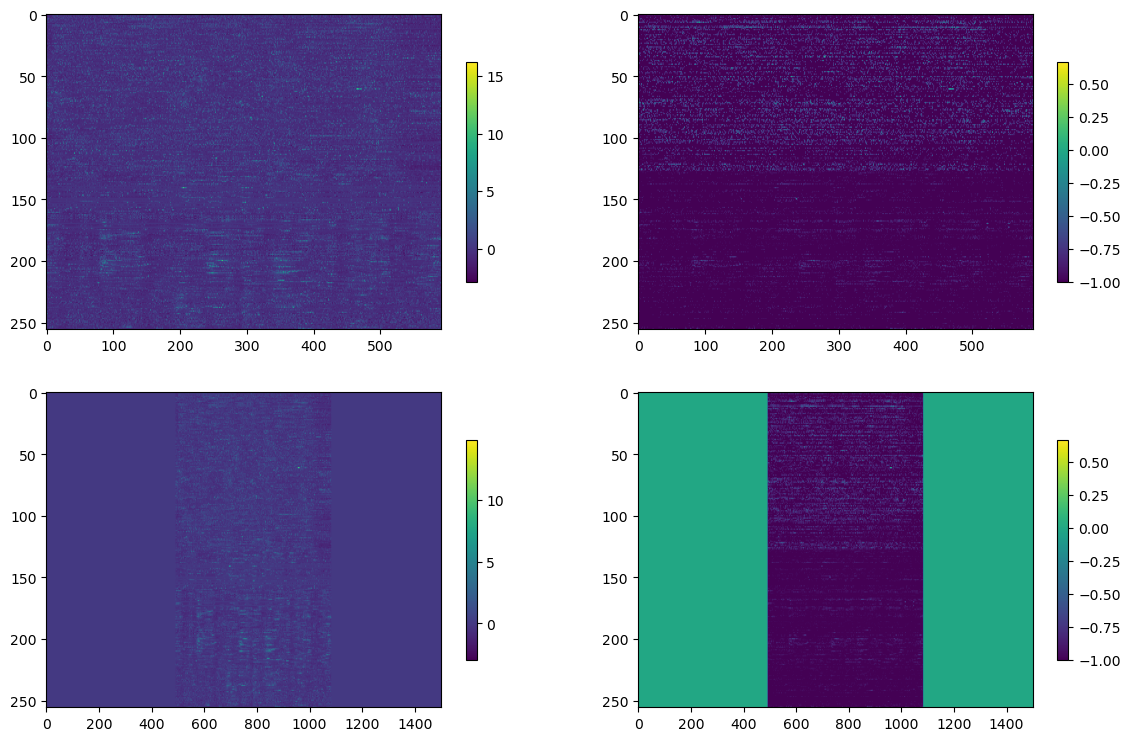

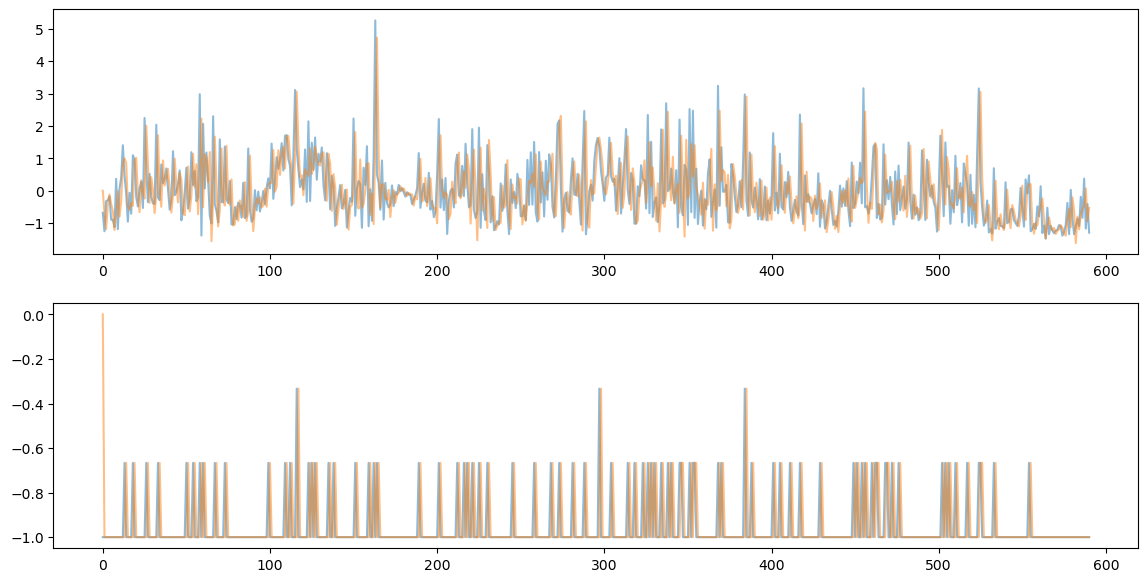

In [12]:
idx = 10
chan = 3

step = 1 if adaptation_config.fs_whisper == 50 else 2

dataset = train_dataset
data = data_train

voltage = scalerV.transform(data['voltage_list'][idx]).T
spikes = scalerS.transform(data['spike_list'][idx]).T

print("Original shape", voltage.shape)

plt.figure(figsize=(14, 9))

# with scaling
plt.subplot(221)
plt.imshow(voltage, aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(spikes, aspect='auto')
plt.colorbar(shrink=0.7)

# Augmentations etc.
input_features = dataset[idx]['input_features'].numpy()
if adaptation_config.inputs_stack == "concat":
    cfg = adaptation_config
    new_input_features = np.empty((cfg.n_electrodes, cfg.n_features, (cfg.max_duration * cfg.fs_whisper)))
    new_input_features[:, 0, :] = input_features[:cfg.n_electrodes, :]
    new_input_features[:, 1, :] = input_features[cfg.n_electrodes:, :]
    input_features = new_input_features

start_idx = np.arange(input_features.shape[-1] - 1)[(np.diff(np.sum(np.abs(input_features[:, 0, :]), axis=0)) > 0)][0]
start_idx = 0 if start_idx == 2 else start_idx
print(start_idx)
    
plt.subplot(223)
plt.imshow(input_features[:, 0], aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(input_features[:, 1], aspect='auto')
plt.colorbar(shrink=0.7)


plt.figure(figsize=(14, 7))

plt.subplot(211)
plt.plot(voltage[chan], alpha=0.5)
plt.plot(input_features[chan, 0, start_idx:start_idx+voltage.shape[1]:step], alpha=0.5)


plt.subplot(212)
plt.plot(spikes[chan], alpha=0.5)
plt.plot(input_features[chan, 1, start_idx:start_idx+voltage.shape[1]:step], alpha=0.5)
print(data_train['sentence_list'][idx])
dataset[0]['input_features'].shape

## Training setup

### Setup wandb and hugging face login

## Set training parameters

In [13]:
import wandb
wandb.login(key="84800673dd80a5eac8bb77b02728e733f806fd10")

experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP3.2_only-adapter"
experiment_path.mkdir(parents=True, exist_ok=True)


config_names = ["augment_config.json", "preprocess_config.json", "adaptataion_config.json"]
configs = [augment_config, preprocess_config, adaptation_config]

# for i in range(len(config_names)):
#     save_config(configs[i], experiment_path / config_names[i])

batch_size = 16
epoch_length = int(len(train_dataset) / batch_size)

training_args = Seq2SeqTrainingArguments(
    output_dir=experiment_path,  # change to a repo name of your choice
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=int(16 / batch_size),  # increase by 2x for every 2x decrease in batch size
    learning_rate=2.5e-5,
    num_train_epochs=8,
    warmup_steps=1 * epoch_length,
    gradient_checkpointing=True,
    fp16=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    generation_max_length=32,
    save_steps=int(epoch_length / 2),
    eval_steps=int(epoch_length / 2),
    logging_steps=int(epoch_length / 16),
    report_to=["wandb"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

# initialize data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

# defining here because using a concerete tokenizer instance! 
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


optimizer = torch.optim.AdamW(included_params, lr=1e-5)

# initialize trainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    optimizers=(optimizer, None)
)

wandb: Currently logged in as: altime. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/atimcenko/.netrc
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Train

In [ ]:
trainer.train()

`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
275,0.643300,0.811521,38.577665
550,0.671800,0.795911,37.613678
825,0.526100,0.782257,37.031648
1100,0.558600,0.775047,36.267734
1375,0.444100,0.787112,37.286286
1650,0.491200,0.783170,36.267734


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead.

### Evaluate from checkpoint

In [32]:
experiment_path

PosixPath('/mnt/beegfs/home/atimcenko/at_code/brain2text/data/experiments/openai/whisper-large-v3/experiment-6_features-512_interleave_augment-eval_model-max')

In [29]:
checkpoint_path = experiment_path / "checkpoint-1375"
model = WhisperForConditionalGeneration.from_pretrained(checkpoint_path).to('cuda')

In [21]:
for idx in range(0, 10):
    true_text = data_test['sentence_list'][idx]
    print(f"True: {true_text}")
    input_tensor = train_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 512, 3000))
    ids = model.generate(input_tensor).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

True: Theocracy reconsidered.
Pred: Nuclear rockets can destroy airfields with ease.

True: Rich purchased several signed lithographs.
Pred: The best way to learn is to solve extra problems.

True: So rules we made, in unabashed collusion.
Pred: The spray will be used in first division matches next season.

True: Lori's costume needed black gloves to be completely elegant.
Pred: Our experiment's positive outcome was unexpected.

True: The tooth fairy forgot to come when Roger's tooth fell out.
Pred: Alimony harms a divorced man's wealth.

True: That stinging vapor was caused by chloride vaporization.
Pred: She uses both names interchangeably.

True: Before Thursday's exam, review every formula.
Pred: The misquote was retracted with an apology.

True: Wildfire near Sunshine forces park closures.
Pred: Critics fear the erosion of consumer protections and environmental standards.

True: The word means it won't boil away easily, nothing else.
Pred: Her lips, moist and parted, spoke his nam

**Change num_beans**

In [31]:
for idx in range(20, 30):
    true_text = sentences_test[idx]
    print(f"True: {true_text}")
    input_tensor = eval_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 80, 3000))
    ids = model.generate(input_tensor).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

True: to some extent predispositions are shaped by exposure to group environments
Pred: the last time we talked about the explosion the explosion happened

True: an adult male baboon's teeth are not suitable for eating shellfish
Pred: in a long long long long time there was not much to say

True: in this context it would do well for us to bear in mind the vision of peace
Pred: in the long run we have to go where we need to be before we can go where we need to be before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before

In [39]:
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [8]:
model.encoder

NameError: name 'model' is not defined